# MGSC 404 Final project: Bixi-Sharing Optimization Project

Jonathan Gaudaire (260966733) <br>
Kenzy Riad (260958089) <br>
Sarah-Ève Roberge (260989700) <br>
Hiba Belghazi (260918277) <br>
Artiom Bakhrakh (260986364)

# 1 - Introduction

BIXI is a bike-sharing system based in Montreal with more than 250,000 users across the city. Therefore, the company needs to manage efficiently a large number of stations and bikes to keep operating correctly. Apart from the number of stations, their capacity and their location, BIXI also needs to alleviate the supply and demand mismatch in its network. One solution found is to rellocate manually bikes from dock-constrained areas to bike-constrained areas. There are many strategies available to the company to reposition efficiently their bikes. However, some strategies are more costly than others, as it can be assumed that the number of bikes to be repositioned and the cost of repositioning them have a positive linear relationship. <br>
<br>
_What repositioning strategy should the company use to minimize the number of bikes that need to be relocated?_

## 3.0 Import libraries and data

In [1]:
from datascience import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import folium
from gurobipy import *
from gurobipy import GRB

In [2]:
# First we import our data.
tripsQ3 = Table.read_table("Divvy_Trips_2017_Q3.csv")

In [3]:
# Create column "Hour" to sperate the date and the hour.

def hour(number):
    return number.split(' ')[1][0:2]

Start_time = tripsQ3.apply(hour,"start_time")

tripsQ3 = tripsQ3.with_column("Hour", Start_time)
tripsQ3

trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,Hour
16734065,9/30/2017 23:59:58,10/1/2017 00:05:47,1411,349,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1985,23
16734064,9/30/2017 23:59:53,10/1/2017 00:05:47,3048,354,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1979,23
16734063,9/30/2017 23:59:06,10/1/2017 00:02:52,2590,226,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Subscriber,Male,1993,23
16734062,9/30/2017 23:58:56,10/1/2017 00:07:37,551,521,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Customer,nan,nan,23
16734061,9/30/2017 23:58:47,10/1/2017 00:07:37,1287,530,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Subscriber,Female,1994,23
16734060,9/30/2017 23:58:45,10/1/2017 00:16:37,6132,1072,478,Rockwell St & Eastwood Ave,117,Wilton Ave & Belmont Ave,Subscriber,Male,1980,23
16734059,9/30/2017 23:57:19,10/1/2017 00:05:36,5235,497,114,Sheffield Ave & Waveland Ave,296,Broadway & Belmont Ave,Subscriber,Male,1988,23
16734058,9/30/2017 23:57:12,10/1/2017 00:00:46,54,214,87,Racine Ave & Fullerton Ave,127,Lincoln Ave & Fullerton Ave,Subscriber,Male,1977,23
16734057,9/30/2017 23:56:59,10/1/2017 00:20:17,3823,1398,90,Millennium Park,86,Eckhart Park,Customer,nan,nan,23
16734056,9/30/2017 23:56:52,10/1/2017 00:14:44,5794,1072,296,Broadway & Belmont Ave,268,Lake Shore Dr & North Blvd,Subscriber,Female,1990,23


In [4]:
stations = Table.read_table("Divvy_Stations_2017_Q3Q4.csv")
stations

id,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7
2,Buckingham Fountain,Chicago,41.8764,-87.6203,27,6/10/2013 10:43,nan
3,Shedd Aquarium,Chicago,41.8672,-87.6154,55,6/10/2013 10:44,nan
4,Burnham Harbor,Chicago,41.8563,-87.6133,23,6/10/2013 10:46,nan
5,State St & Harrison St,Chicago,41.8741,-87.6277,23,6/10/2013 10:46,nan
6,Dusable Harbor,Chicago,41.885,-87.6128,39,6/10/2013 11:18,nan
7,Field Blvd & South Water St,Chicago,41.8863,-87.6175,19,6/19/2013 10:00,nan
9,Leavitt St & Archer Ave,Chicago,41.8288,-87.6806,19,6/21/2013 9:33,nan
11,Jeffery Blvd & 71st St,Chicago,41.7666,-87.5765,11,6/21/2013 9:39,nan
12,South Shore Dr & 71st St,Chicago,41.7664,-87.5657,15,6/21/2013 10:00,nan
13,Wilton Ave & Diversey Pkwy,Chicago,41.9324,-87.6527,27,6/22/2013 18:29,nan


# 3.1 - Data Exploration

###### Trip duration distribution

The histogram below portrays the trip durations in quarter 3.


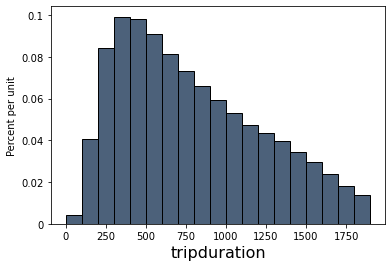

In [5]:
tripsQ3.hist("tripduration", bins = np.arange(0,2000,100))
print("The histogram below portrays the trip durations in quarter 3.")

###### Average Trip Duration

In [6]:
#Average trip duration of all trips in Q3
average_seconds = np.average(tripsQ3["tripduration"])
average_minutes = average_seconds/60
print("Average Trip Duration: ", average_minutes,'minutes')

Average Trip Duration:  17.4041417797 minutes


###### Map of the stations

In [7]:
#Mapping all stations in the data
capacity_map = Table().with_columns(["lat",stations.column(3)],["lon",stations.column(4)],["demand",stations.column(5)])
capacity_station = folium.Map(location=[41.8781, -87.6298], zoom_start=13)

for lat, lon, demand in zip(capacity_map.column(0),capacity_map.column(1),capacity_map.column(2)):
    folium.CircleMarker(
        [lat, lon],
        color='green',
        radius=0.15*(demand),
        ).add_to(capacity_station)
capacity_station

As we can see here, the stations are concentrated downtown. Therefore, if most stations that need to be rebalanced are in that area, Bixi can focus only on this area and not consider the remaining stations. Indeed, if they are considered in the repositioning, they will increase significatively the company's costs.

###### Customer and Revenue Analysis

In [8]:
Subscribers = tripsQ3.group('usertype')
Subscribers

usertype,count
Customer,441623
Dependent,3
Subscriber,1166644


In [9]:
print(Subscribers.column('count')[0]*100/(sum(Subscribers.column('count'))),'% of rides are made by guest customers.')
print(Subscribers.column('count')[2]*100/(sum(Subscribers.column('count'))),'% of rides are made by subscribers.')

27.4595061774 % of rides are made by guest customers.
72.5403072867 % of rides are made by subscribers.


###### Station Analysis

In [10]:
#Grouping by from station id
#From station ID
tripsQ3.group(['from_station_id']).sort('count', descending=True)

from_station_id,count
35,52110
76,26507
268,26342
177,26251
85,20673
192,20231
91,17171
90,16260
77,15967
3,15864


Station 35 has the highest # of bikes taken from it.

In [11]:
#To station id
tripsQ3.group(['to_station_id']).sort('count', descending=True)

to_station_id,count
35,56631
268,29650
177,27759
76,25005
85,22102
192,20703
90,18441
77,17198
91,15953
3,15120


Station 35 has the highest # of bikes taken to it. As we can see, some stations have a high number of bikes taken from and to it. Therefore, if the difference between the "to" table and the "from" table is close to 0, we will not need to include this station in the repositioning algorithm.

### Station selection: 

Below, we determine which stations we should focus on by determining which stations have the most surplus of bikes and which have the most deficiency in number of bikes. are the most popular stations and need bikes to be added or removed. 

In [12]:
# Here, we count the number of trips "from" each station. 
stations_from_count = tripsQ3.group(['from_station_id'])
stations_from_count

from_station_id,count
2,8375
3,15864
4,11260
5,3090
6,12785
7,5112
9,294
11,136
12,432
13,5277


In [13]:
# Here, we count the number of trips "to" each station.
stations_to_count = tripsQ3.group(['to_station_id'])
stations_to_count

to_station_id,count
2,8165
3,15120
4,11332
5,3133
6,10597
7,4742
9,323
11,134
12,454
13,5015


In [14]:
# Then, we found the difference by subtracting column with index 1 of the "to" stations count from the column with index 1 of the "from" stations count. 

# Then, we made a table called "stations_difference" with columns 'station_id' from the first in the above cell and a second column with the difference of 'to' minus 'from' trip count for each station. 

# We then selected 20 stations,in this cell we selected the 10 stations with the highest net difference and divided the count by 92 to account for the number of days in a quarter.

# Then, we associated each station with its coordinates and rounded the counts.

stations_difference_count = (stations_to_count.column(1)-stations_from_count.column(1))/92
stations_difference = Table()
stations_difference = stations_difference.with_columns('station_id',stations_to_count.column(0),'count',stations_difference_count)
highest_ten = stations_difference.where(stations_difference.column(1) >= 13.3804)

highest_arr = [31,69,73,78,100,111,160,192,201,246]
highest_ten_coor = stations.take(highest_arr).select(0,1,3,4,5)
highest_ten = highest_ten.with_columns('name', highest_ten_coor.column(1), 'latitude', highest_ten_coor.column(2), 'longitude', highest_ten_coor.column(3), 'dpcapacity',highest_ten_coor.column(4))
ceiled_highest_ten = np.ceil(highest_ten.column(1))
highest_ten = highest_ten.drop('count')
highest_ten = highest_ten.with_column('count', ceiled_highest_ten)
highest_ten

station_id,name,latitude,longitude,dpcapacity,count
35,Streeter Dr & Grand Ave,41.8923,-87.612,47,50
77,Clinton St & Madison St,41.8822,-87.6411,31,14
85,Michigan Ave & Oak St,41.901,-87.6238,23,16
90,Millennium Park,41.881,-87.6241,47,24
114,Sheffield Ave & Waveland Ave,41.9494,-87.6545,27,14
125,Rush St & Hubbard St,41.8902,-87.6262,23,15
177,Theater on the Lake,41.9263,-87.6308,23,17
211,St. Clair St & Erie St,41.8944,-87.6227,19,19
220,Hampden Ct & Diversey Pkwy,41.9326,-87.6424,23,20
268,Lake Shore Dr & North Blvd,41.9117,-87.6268,39,36


In [15]:
# In this cell we selected the 10 stations with the highest net difference and divided the count by 92 to account for the number of days in a quarter.

# Then, we associated each station with its coordinates and rounded the counts.

lowest_ten = stations_difference.where(stations_difference.column(1) <= -12.3695)
lowest_ten

lowest_arr = [4,68,71,79,85,88,157,172,176,264]
lowest_ten_coor = stations.take(lowest_arr).select(0,1,3,4,5)
lowest_ten = lowest_ten.with_columns('name', lowest_ten_coor.column(1), 'latitude', lowest_ten_coor.column(2), 'longitude', lowest_ten_coor.column(3), 'dpcapacity', lowest_ten_coor.column(4))
floored_lowest_ten = np.floor(lowest_ten.column(1))
lowest_ten = lowest_ten.drop('count')
lowest_ten = lowest_ten.with_column('count', floored_lowest_ten)
lowest_ten

station_id,name,latitude,longitude,dpcapacity,count
6,Dusable Harbor,41.885,-87.6128,39,-24
76,Lake Shore Dr & Monroe St,41.881,-87.6167,39,-17
81,Daley Center Plaza,41.8842,-87.6296,39,-13
91,Clinton St & Washington Blvd,41.8834,-87.6412,31,-14
97,Field Museum,41.8653,-87.6179,55,-13
100,Orleans St & Merchandise Mart Plaza,41.8882,-87.6364,35,-20
174,Canal St & Madison St,41.8821,-87.6398,35,-19
191,Canal St & Monroe St (*),41.8809,-87.6395,28,-18
195,Columbus Dr & Randolph St,41.8847,-87.6195,47,-68
287,Franklin St & Monroe St,41.8803,-87.6352,27,-37


### Determine the number of bikes to move per hour: 

Then we found the average number of trips per station per hour and found the difference between bikes that enter a station and those that exit a station. We assumed the starting point is that each station is filled at 70 percent of its capacity which means we would not need to add or remove any bikes. We then used the data to see the movement of bikes given this "null" starting position. We found that not enough bikes move per hour to warrant moving them by truck. 

In [16]:
# Using our hour column to make a pivot table with the number of trips "to" each station per hour. 
trips_by_hour_to = tripsQ3.pivot('Hour', 'to_station_id')
trips_by_hour_to

to_station_id,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2,24,17,22,3,6,17,33,87,185,256,473,658,738,815,858,836,785,726,647,353,211,188,150,77
3,23,20,12,4,1,14,64,344,509,870,1301,1559,1607,1538,1574,1341,1237,994,860,570,330,163,123,62
4,28,8,6,2,3,33,149,269,334,523,697,926,963,1053,1001,982,1117,1086,942,631,328,134,70,47
5,31,10,17,5,9,20,32,47,163,143,100,158,205,174,159,190,267,441,292,219,180,104,92,75
6,42,14,4,1,3,43,67,208,288,427,647,851,899,846,973,982,1097,1179,668,522,348,247,145,96
7,29,30,14,8,1,43,78,174,267,179,188,249,281,265,247,386,503,597,386,261,216,117,156,67
9,4,1,3,2,0,8,5,6,15,7,10,9,22,15,6,22,61,30,28,15,17,9,11,17
11,0,5,0,0,0,0,0,8,5,3,5,7,4,7,7,18,21,9,8,10,5,7,5,0
12,7,7,1,0,0,1,1,4,11,5,17,42,35,37,43,35,21,38,32,36,31,29,12,9
13,43,30,20,11,44,175,233,556,320,175,152,193,207,190,167,219,308,511,475,365,234,149,133,105


In [17]:
# Using our hour column to make a pivot table with the number of trips "from" each station per hour. 

trips_by_hour_from = tripsQ3.pivot('Hour', 'from_station_id')
trips_by_hour_from

from_station_id,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2,41,19,12,10,2,5,28,41,102,221,446,614,756,781,826,814,851,742,602,543,356,286,161,116
3,25,20,5,6,2,11,30,106,151,308,513,1150,1632,1942,1916,2034,2032,1245,880,576,348,329,322,281
4,45,13,10,2,4,11,120,196,284,374,594,792,914,1037,995,984,1048,1156,1052,804,449,215,83,78
5,29,13,7,6,4,17,80,112,266,176,138,152,200,230,133,176,210,229,217,198,166,142,123,66
6,87,22,7,2,1,19,61,162,311,458,765,1072,1031,1110,1120,1173,1149,1209,945,686,488,390,335,182
7,6,13,9,5,7,66,86,241,576,382,290,303,311,266,281,262,359,664,450,223,140,69,71,32
9,6,4,1,1,0,7,42,15,7,3,12,9,16,26,9,21,37,23,7,13,10,11,6,8
11,0,4,0,0,0,0,0,7,5,2,8,20,20,9,8,7,2,5,5,15,3,9,5,2
12,4,4,1,1,0,3,4,7,11,11,18,34,38,45,44,31,22,30,41,30,21,19,10,3
13,67,24,24,4,0,41,196,205,198,158,204,229,232,259,280,265,387,813,626,397,263,173,127,105


In [18]:
# Here we make a table called "diff" (difference) with one column called "station_id". 

# Then we created a variable with all the hours and wrote a for loop to go through each one and subtract "to" trips in that hour from "from" trip in that hour.

# We then added these values to "diff" and divided each value by 92 to get the average of that day at that hour since our dataset contains the whole quarter (92 days). 

diff = Table().with_columns("station_id", trips_by_hour_from.column("from_station_id"))

hour = ["00", "01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]

for i in hour:
    from_to3 = trips_by_hour_to.column(i) - trips_by_hour_from.column(i)
    diff = diff.with_columns(i, from_to3/92)
    
diff.show(20)

station_id,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2,-0.184783,-0.0217391,0.108696,-0.076087,0.0434783,0.130435,0.0543478,0.5,0.902174,0.380435,0.293478,0.478261,-0.195652,0.369565,0.347826,0.23913,-0.717391,-0.173913,0.48913,-2.06522,-1.57609,-1.06522,-0.119565,-0.423913
3,-0.0217391,0,0.076087,-0.0217391,-0.0108696,0.0326087,0.369565,2.58696,3.8913,6.1087,8.56522,4.44565,-0.271739,-4.3913,-3.71739,-7.53261,-8.6413,-2.72826,-0.217391,-0.0652174,-0.195652,-1.80435,-2.16304,-2.38043
4,-0.184783,-0.0543478,-0.0434783,0,-0.0108696,0.23913,0.315217,0.793478,0.543478,1.61957,1.11957,1.45652,0.532609,0.173913,0.0652174,-0.0217391,0.75,-0.76087,-1.19565,-1.88043,-1.31522,-0.880435,-0.141304,-0.336957
5,0.0217391,-0.0326087,0.108696,-0.0108696,0.0543478,0.0326087,-0.521739,-0.706522,-1.11957,-0.358696,-0.413043,0.0652174,0.0543478,-0.608696,0.282609,0.152174,0.619565,2.30435,0.815217,0.228261,0.152174,-0.413043,-0.336957,0.0978261
6,-0.48913,-0.0869565,-0.0326087,-0.0108696,0.0217391,0.26087,0.0652174,0.5,-0.25,-0.336957,-1.28261,-2.40217,-1.43478,-2.86957,-1.59783,-2.07609,-0.565217,-0.326087,-3.01087,-1.78261,-1.52174,-1.55435,-2.06522,-0.934783
7,0.25,0.184783,0.0543478,0.0326087,-0.0652174,-0.25,-0.0869565,-0.728261,-3.3587,-2.20652,-1.1087,-0.586957,-0.326087,-0.0108696,-0.369565,1.34783,1.56522,-0.728261,-0.695652,0.413043,0.826087,0.521739,0.923913,0.380435
9,-0.0217391,-0.0326087,0.0217391,0.0108696,0,0.0108696,-0.402174,-0.0978261,0.0869565,0.0434783,-0.0217391,0,0.0652174,-0.119565,-0.0326087,0.0108696,0.26087,0.076087,0.228261,0.0217391,0.076087,-0.0217391,0.0543478,0.0978261
11,0,0.0108696,0,0,0,0,0,0.0108696,0,0.0108696,-0.0326087,-0.141304,-0.173913,-0.0217391,-0.0108696,0.119565,0.206522,0.0434783,0.0326087,-0.0543478,0.0217391,-0.0217391,0,-0.0217391
12,0.0326087,0.0326087,0,-0.0108696,0,-0.0217391,-0.0326087,-0.0326087,0,-0.0652174,-0.0108696,0.0869565,-0.0326087,-0.0869565,-0.0108696,0.0434783,-0.0108696,0.0869565,-0.0978261,0.0652174,0.108696,0.108696,0.0217391,0.0652174
13,-0.26087,0.0652174,-0.0434783,0.076087,0.478261,1.45652,0.402174,3.81522,1.32609,0.184783,-0.565217,-0.391304,-0.271739,-0.75,-1.22826,-0.5,-0.858696,-3.28261,-1.6413,-0.347826,-0.315217,-0.26087,0.0652174,0


In [19]:
# Here we filter our table by taking only the stations with the highest surplus of bikes. We use the index for each station. 

highest_arr = [31,69,73,78,100,111,160,192,201,246]
highest_ten = diff.take(highest_arr)
highest_ten

station_id,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
35,-0.826087,-0.326087,-0.152174,0.0978261,0.0652174,0.23913,2.17391,2.38043,3.18478,6.42391,14.0652,16.8261,11.4891,10.5543,6.78261,1.91304,0.554348,1.84783,-3.93478,-4.41304,-4.70652,-5.65217,-7.8587,-1.58696
77,0.663043,-0.0434783,0.130435,0.108696,0.0543478,1.16304,-1.46739,-4.18478,-6.26087,-2.56522,-0.880435,0.0978261,0.554348,-0.206522,-0.119565,4.30435,27.6957,1.58696,-7.44565,-1.71739,0.217391,0.467391,0.608696,0.619565
85,0.0652174,0.228261,-0.0652174,-0.130435,0.0217391,0.73913,0.891304,4.26087,4.27174,1.29348,1.51087,3.09783,4.08696,4.20652,2.18478,-0.0434783,-2.70652,-3.95652,-2.65217,-1.91304,-0.119565,-0.25,0.75,-0.23913
90,-0.358696,-0.195652,-0.119565,0.0434783,-0.0543478,0.554348,1.68478,5.6087,8.55435,2.6087,4.26087,3.34783,4.54348,2.95652,1.75,1.21739,-0.271739,-5.1413,-0.336957,-0.119565,-2.58696,-2.58696,-0.945652,-0.706522
114,-0.184783,-0.0217391,-0.0869565,-0.0543478,-0.0108696,0.152174,0.956522,0.923913,1.86957,-0.0978261,1.67391,2.57609,6.90217,4.8913,1.54348,-0.271739,-3.90217,-2.03261,3.88043,1.1087,0.5,-1.92391,-4.03261,-0.684783
125,-0.130435,-0.271739,-0.0217391,-0.076087,-0.0434783,-0.0108696,1.34783,4.46739,14.1848,4.91304,0.76087,0.369565,0.184783,0.391304,0.369565,-0.521739,-3.3587,-3.16304,-1.19565,-1.40217,-0.836957,-1.31522,-0.23913,-0.271739
177,-0.108696,-0.0108696,0.0652174,-0.130435,-0.0217391,0.358696,0.434783,1.92391,-0.358696,1.83696,6.83696,7.73913,8.34783,5.04348,2.55435,-2.17391,-2.02174,-2.1087,-2.32609,-4.04348,-3.8913,-0.586957,-0.576087,-0.391304
211,-0.0217391,0.0869565,-0.228261,0,0.25,3.07609,9.22826,13.5652,8.29348,3.66304,0.108696,0.51087,0.48913,-0.0108696,-0.76087,-3.20652,-6.27174,-4.20652,-1.23913,-1.82609,-1.42391,-0.663043,-0.369565,-0.108696
220,0.119565,0.0217391,0.195652,0.108696,-0.206522,-0.945652,-0.902174,-5.11957,-3.61957,-0.913043,0.0434783,-1.09783,-0.532609,-0.423913,0.195652,0.945652,3.59783,9.55435,6.86957,5.03261,3.20652,1.48913,1.30435,0.641304
268,-0.0217391,-0.0543478,0.0326087,0,-0.0108696,0.271739,0.75,-0.402174,0.26087,3.01087,5.31522,7.75,9.88043,8.5,3.76087,-4.56522,-4.13043,8.16304,11.4239,-5.56522,-7.09783,-1.3913,-0.108696,0.184783


In [20]:
# Here we filter our table by taking only the stations with the lowest number of bikes. We use the index for each station. 

lowest_arr = [4,68,71,79,85,88,157,172,176,264]
lowest_ten = diff.take(lowest_arr)
lowest_ten

station_id,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
6,-0.48913,-0.0869565,-0.0326087,-0.0108696,0.0217391,0.26087,0.0652174,0.5,-0.25,-0.336957,-1.28261,-2.40217,-1.43478,-2.86957,-1.59783,-2.07609,-0.565217,-0.326087,-3.01087,-1.78261,-1.52174,-1.55435,-2.06522,-0.934783
76,-0.51087,-0.0543478,0,-0.0543478,0,0.173913,0.576087,1.03261,0.630435,1.22826,-0.380435,0.793478,-1.25,-0.782609,0.130435,0.663043,-1.94565,-1.07609,-3.47826,-3.1413,-2.56522,-2.58696,-2.31522,-1.41304
81,-0.195652,0.0543478,0.0543478,0.195652,0,0.0217391,1.03261,15.1413,33.163,11.4022,1.78261,-0.48913,0.880435,0.369565,-0.978261,-1.70652,-13.3478,-39.0652,-13.8261,-2.33696,-1.33696,-1.17391,-0.902174,-1.1087
91,-0.293478,0.0326087,0.0326087,0.0108696,-0.0217391,1.46739,-12.3152,-17.2717,-10.8804,-5.30435,-1.25,-0.608696,0.5,0.847826,3.26087,15.1522,18.3696,2.09783,-4.98913,-2.33696,-0.163043,-0.0652174,0.293478,0.195652
97,-0.184783,-0.119565,-0.0434783,0.0217391,0,0.076087,0.586957,1.29348,1.36957,2.04348,3.19565,3.63043,0.434783,-0.271739,-2.22826,-4.88043,-7.33696,-4.81522,-0.565217,0.75,-0.467391,-1.08696,-1.16304,-2.78261
100,-0.23913,-0.271739,-0.108696,0.0326087,0.0326087,0.282609,4.97826,14.1957,27.8478,10.6304,0.836957,0.978261,-0.152174,-0.108696,-1.32609,-3.67391,-13.8478,-35.6848,-13.6196,-5.33696,-2.56522,-1.13043,-0.815217,-0.23913
174,0.076087,-0.0869565,-0.0108696,0.0217391,0.0326087,0.228261,-1.86957,-8.59783,-6.41304,-1.68478,-1.11957,-1.30435,-1,1.07609,1.8587,6.81522,9.55435,-7.47826,-5.22826,-2.33696,-0.880435,-0.108696,0.195652,0.217391
191,-0.076087,-0.0108696,0.0108696,-0.0217391,0.0434783,0.413043,2.92391,-0.413043,-5.26087,-0.184783,0.0326087,-0.913043,-0.554348,-0.51087,-1.06522,-2.01087,-2.28261,-3.5,-1.65217,-0.728261,-1.09783,-0.358696,-0.304348,-0.0434783
195,0.076087,-0.0217391,-0.0869565,-0.0108696,0.0108696,0.206522,-0.108696,3.3587,5.02174,-2.86957,-2.88043,-6.01087,-4.19565,-5.16304,-3.94565,-8.55435,-17.1304,-12.8261,-6.44565,-2.59783,-1.15217,-1.27174,-0.663043,0.0217391
287,-0.336957,0.217391,-0.0652174,-0.0652174,0.108696,0.923913,6.43478,20.9348,33.163,12.1848,2.93478,-1.67391,-2.84783,-0.184783,-0.98913,-7.79348,-23.3696,-50.0543,-18.6522,-2.82609,-1.72826,-1.43478,-0.521739,-0.369565


### Number of bikes to move per day: 

Since hours gave us numbers that were too small, we decided to filter by day. So we found the average number of trips per station per day and found the difference between bikes that enter a station and those that exit a station. We assumed the starting point is that each station is filled at 70 percent of its capacity which means we would not need to add or remove any bikes. We then used the data to see the movement of bikes given this "null" starting position. After finding the average difference from and to a station by day, we filtered the data by stations that had most deficiencies in bikes, and those that had most surplus in bikes (found in first part of data exploration). 

In [ ]:
# Here we use "to_datetime" from pandas to turn our dates into in the actually day (Monday, Tuesday etc.) in which the trop took place.
# We had to use dataframe instead of table to use this function. 

dfQ3 = pd.read_csv("Divvy_Trips_2017_Q3.csv")

dfQ3['start_day'] = pd.to_datetime(dfQ3['start_time']).dt.day_name()
dfQ3['end_day'] = pd.to_datetime(dfQ3['end_time']).dt.day_name()

In [ ]:
# We then created a pivot table that shows how many trips started "from" each station on each day. 

Trips_startday_from = dfQ3.pivot_table(index = 'from_station_id', columns = 'start_day', values = 'trip_id',
                          aggfunc='count')
Trips_startday_from

In [ ]:
# We did the same to count how many trips ended "to" each station on each day. 

Trips_startday_to = dfQ3.pivot_table(index = 'to_station_id', columns = 'start_day', values = 'trip_id',
                          aggfunc='count')

Trips_startday_to

In [ ]:
# Then we created a table and wrote a function to find the difference to and from on each day for all trips at each station.
# We divided each difference by 13.14 because that the approximate number of mondays, tuesday etc. for the quarter so we get the average difference on "average" monday for instance.
 
diff_day = Table().with_columns("station_id", trips_by_hour_from.column("from_station_id"))

day = ["Friday", "Monday","Saturday","Sunday","Thursday","Tuesday","Wednesday"]

for i in day:
    
    from_to3 = Trips_startday_to[i] - Trips_startday_from[i]
    diff_day = diff_day.with_columns(i, from_to3/13.14)

diff_day

In [ ]:
# We filtered our table by taking only the stations with the highest surplus and lowest nnumber of bikes.

highest_arr = [31,69,73,78,100,111,160,192,201,246]
highest_ten = diff_day.take(highest_arr)
highest_ten

In [ ]:
lowest_arr = [4,68,71,79,85,88,157,172,176,264]
lowest_ten = diff_day.take(lowest_arr)
lowest_ten

## Trip Duration

In [ ]:
# We made a pivot table with the trip duration per station per day. 

Trip_duration_day = dfQ3.pivot_table(index = 'to_station_id', columns = 'start_day', values = 'tripduration',
                          aggfunc='count')

Trip_duration_day

In [ ]:
# We found the "average" trip duration per station per day by dividing by 13.14 and then converted this to minutes by dividing by 60.

Trip_duration = Table().with_columns("station_id", trips_by_hour_from.column("from_station_id"))

day = ["Friday", "Monday","Saturday","Sunday","Thursday","Tuesday","Wednesday"]

for i in day:
    
    trip_duration = Trip_duration_day[i]
    Trip_duration = Trip_duration.with_columns(i, ((trip_duration/13.14)/60))

Trip_duration

In [ ]:
# We again filtered our table by stations with surplus and low number of bikes. 

highest_arr = [31,69,73,78,100,111,160,192,201,246]
highest_ten = Trip_duration.take(highest_arr)
highest_ten

In [ ]:
# To visualize this, we plotted the average trip duration per day for stations with surplus number of bikes. 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Monday = highest_ten['Monday'].mean()
Tuesday = highest_ten['Tuesday'].mean()
Wednesday = highest_ten['Wednesday'].mean()
Thursday = highest_ten['Thursday'].mean()
Friday = highest_ten['Friday'].mean()
Saturday = highest_ten['Saturday'].mean()
Sunday = highest_ten['Sunday'].mean()

Average_Trip_Duration = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

Days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax.bar(Days, Average_Trip_Duration)
plt.show()



In [ ]:
lowest_arr = [4,68,71,79,85,88,157,172,176,264]
lowest_ten = Trip_duration.take(lowest_arr)
lowest_ten

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Monday = lowest_ten['Monday'].mean()
Tuesday = lowest_ten['Tuesday'].mean()
Wednesday = lowest_ten['Wednesday'].mean()
Thursday = lowest_ten['Thursday'].mean()
Friday = lowest_ten['Friday'].mean()
Saturday = lowest_ten['Saturday'].mean()
Sunday = lowest_ten['Sunday'].mean()

Average_Trip_Duration = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

Days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax.bar(Days, Average_Trip_Duration)
plt.show()

# Pandas for objective function

In [ ]:
dfQ3 = pd.read_csv("Divvy_Trips_2017_Q3.csv")

In [ ]:
#importing the file
dfQ4 = pd.read_csv("Divvy_Trips_2017_Q4.csv")

In [ ]:
#importing the file
df_station = pd.read_csv("Divvy_Stations_2017_Q3Q4.csv")



In [ ]:
#new station contains all stations in i and j (20 stations total)
new_station = [35,77,85,90,114,125,177,211,220,268,6,76,81,91,97,100,174,191,195,287]
new_station.sort()



In [ ]:
#only displaying trips we want to see 
dfQ3_filter = dfQ3[(dfQ3["from_station_id"].isin(new_station)) |(dfQ3["to_station_id"].isin(new_station))]
dfQ3_filter["split"]= dfQ3_filter["start_time"].str.split()
dfQ3_filter["day"]= dfQ3_filter["split"].str[0]
dfQ3_filter

In [ ]:
#breakdown of the cost per minute per bike
speed = 40 #km/hour (speed assumption downtown)
consommation = 25
# L/km (truck assumption)
gas_cost = 1.75

wage = 25 # $/hour (reshearch online of BIXI employees' wages)
min =60 #(60 minutes in hour)
    
    
cost = (speed/consommation*gas_cost + wage)/60
print("The cost per minute is", cost)

In [ ]:
# These lists represent the ID Station
highest_station_id = [6,76,81,91,97,100,174,191,195,287]
lowest_station_id = [35,77,85,90,114,125,177,211,220,268]

dfQ3_filter2 = dfQ3[(dfQ3["from_station_id"].isin(highest_station_id)) &(dfQ3["to_station_id"].isin(lowest_station_id))]
dfQ3_filter2["duration_min"] = dfQ3_filter2["tripduration"]/60
dfQ3_filter2

### Price Station Cost Table

In [ ]:
avg_time= dfQ3_filter2.pivot_table(index = 'from_station_id', columns = 'to_station_id', values = 'duration_min',
                          aggfunc="mean")
## We assume that with the traffic downtown, the driver goes as the same pace as the bikes.


price_station = avg_time*cost ## price per kilo, one minute to drive 1km.
print("Cost to go from a station i to station j")
price_station

price_station.fillna(1000000, inplace = True)
price_station 


In [ ]:
'''
## This cell is used to create an array of the cost per minute of moving bikes.
price_ij = []
for i in range(10):
    for j in range(10):
        m = price_station.iloc[i,[j]]
        price_ij.append(m)
print(len(price_ij))
'''

## Capacity Constraint seperated with lowest and highest

In [ ]:
# These lists represent the ID Station
highest_station_id = [6,76,81,91,97,100,174,191,195,287]
lowest_station_id = [35,77,85,90,114,125,177,211,220,268]

##### Lowest

In [ ]:
lower_from = dfQ3[dfQ3["from_station_id"].isin(lowest_station_id)]
lower_from =(lower_from.groupby(['from_station_id'])['from_station_id'].count())/92

In [ ]:
lower_to = dfQ3[dfQ3["to_station_id"].isin(lowest_station_id)]
lower_to =(lower_to.groupby(['to_station_id'])['to_station_id'].count())/92

In [ ]:
lower_diff= (lower_from - lower_to)
lower_diff = lower_diff.round()

### Highest

In [ ]:
higher_from = dfQ3[dfQ3["from_station_id"].isin(highest_station_id)]
higher_from =(higher_from.groupby(['from_station_id'])['from_station_id'].count())/92

In [ ]:
higher_to = dfQ3[dfQ3["to_station_id"].isin(highest_station_id)]
higher_to =(higher_to.groupby(['to_station_id'])['to_station_id'].count())/92

#### Difference btw highest and lowest

In [ ]:
higher_diff= (higher_from - higher_to)
higher_diff = higher_diff.round()

In the cell below we creates two tables to demonstrate the capacity, min number of bikes, and number of bikes that need to be picked up from station i, as well as dropped off at station j

In [ ]:
#This step is just creating a list to help including it in the optimization problem later.
lower_ideal_station = []
for i in lower_diff:
    lower_ideal_station.append(i)

higher_ideal_station = []
for i in higher_diff:
    higher_ideal_station.append(i)
higher_ideal_station

#We created treshold regarding the capacity of each stations, since having a too strict constraint on the bikes needed at each station is unrealistic and costly.

df_station_low= df_station[["id", "dpcapacity"]]
df_station_low = df_station_low[df_station_low["id"].isin(lowest_station_id)]
df_station_low["drop_off (I)"]= lower_ideal_station
df_station_low["treshold"]= df_station_low["dpcapacity"]*0.1
df_station_low= df_station_low.round()
df_station_low["max"]= (df_station_low["drop_off (I)"]-df_station_low["treshold"])*-1
df_station_low["min"]= (df_station_low["drop_off (I)"]+df_station_low["treshold"]) *-1


df_station_high= df_station[["id", "dpcapacity"]]
df_station_high = df_station_high[df_station_high["id"].isin(highest_station_id)]
df_station_high["pick_up (I)"] = higher_ideal_station
df_station_high["treshold"]= df_station_high["dpcapacity"]*0.1
df_station_high= df_station_high.round()
df_station_high["max"]= df_station_high["pick_up (I)"]+df_station_high["treshold"]
df_station_high["min"]= df_station_high["pick_up (I)"]-df_station_high["treshold"]


print("Capacity and Djd intervals of Stations Needing Bikes (Djd)")
display(df_station_low)

print("Capacity and Pid intervals of Stations Having Extra Bikes (Pid)")
display(df_station_high)


max_low_neg = []
min_low_neg = []
max_high  =[]
min_high=[]
capacity_high=[]
capacity_low=[]

for i in df_station_low["max"]:
    max_low_neg.append(i)

max_low = list()
for value in max_low_neg:
    absolute = abs(value)
    max_low.append(absolute)
    
for i in df_station_low["min"]:
    min_low_neg.append(i)

min_low = list()
for value in min_low_neg:
    absolute = abs(value)
    min_low.append(absolute)
    
for i in df_station_high["max"]:
    max_high.append(i)
    
for i in df_station_high["min"]:
    min_high.append(i)
    
for i in df_station_high["dpcapacity"]:
    capacity_high.append(i)
    
for i in df_station_low["dpcapacity"]:
    capacity_low.append(i)

## 3.2 Model Formulation and Solution

## Formulation Problem

###### Variables Formulation

**Decision Variables**<br>

$X_{ij}$: The number of bikes moved from a station i to station j in 1 day .<br>

       
<br> 

**Variables for Parameters** <br>

$C_{ij}$: The cost of moving one bike associated with the average time to go from station i to station j in minute
>See table "price station" for more explaination

<br>
$CA$ : Capacity of the truck <br>
$F$ : Ideal percentage of bikes at a dock regarding its capacity (Equilibrium) <br>
$Q_{i}$ : Quantity of docks available at each station i (Capacity)<br>  
$CI$ : The percentage of bikes allowed outside of the ideal number of bikes at station i 
<br>
* Since we assume that we're starting at 70% capacity, the threshold of 10% up/down is 60% to 80% of station's capacity <br>

$A$ : Estimation of bike deficit or surplus at a given station <br>
$I$ : Ideal bike number needed at a station to bring at equilibrium (for both i and j)


$CA = 30 bikes$ <br>
 <br>
$F = 70\%$ <br> 
 We assume that all station are at 70% capacity and we want to maintain this equilibrium. <br>
 <br>
$C = 0.46$ $  <br>
** This cost includes 0.05 dollar for gas per bike and 0.55 dollar for the employee's wage. However, this constant can be change by BIXI with a better  examination of their related costs. ** 
<br>

* The time of going from station i to j $(T_{ij})$ is the same by bike as it is by truck since the targeted station are situated downtown. <br> 

* We assume that there is 92 days in a quarter, thus each day appears 13.14 times in a quarter. 
 <br>
 

$CI = 10\%$ up/down <br>

*** we are assuming that each day is the same ***


### Objective Function

$ Min\sum_{i}^I\sum_{j}^J X_{ij}*C_{ij}$ <br>


### Constraints Formulation


***Deck Capacity Constraint*** <br>

Interval of bikes to relocated for all stations part in i and j. It allows more flexibility to the optimization. <br>
$I_{i} - (Qi*10\%) <= \sum_{j} X_ij <= I_{i} + (Q_{i}*10\%) $ (for i in higher stations)<br>
<br>
$I_{i} - (Qi*10\%)  <= \sum_{i} X_ij$<br>
$I_{i} + (Qi*10\%)  >= \sum_{i} X_ij$<br> 
<br>
<br>
$I_{j} + (Qj*10\%)  <=\sum_{j} X_ij <= I_{j} - (Q_{j}*10\%) $ (for j in lower stations) <br>
<br>
$I_{j} + (Qj*10\%)  <= \sum_{j} X_ij $ <br>
$I_{j} - (Qj*10\%) >= \sum_{j} X_ij$ <br>
<br>





***Truck Constraint*** <br>
<br>
$\sum_{i}X_{ij} <= CA $  for i in list station i <br>

$\sum_{j}X_{ij} <= CA $  for j in list station j <br>
<br>
You cant move more bikes to a station than the maximum truck capacity of 30 bikes. <br>
> If the treshold of picking up or dropping off of bike is over the deck capacity, Pid or Dj is equal to deck capacity. 


## Gurobi Problem

We tried running the model with the initial 10 i stations as well as 10 j stations. However, the model was not working due to many constraints. Therefore, we made a simplified model and wrote all constraints by hand, using only the highest 4 stations (i) and the lowest 4 stations (j). At the end of the file, we put the initial constraints that did not work, however in the following section we put the simplified model, which is working (4 stations). 

In [ ]:
model = Model()
# make a dictionary for the variables Xij
X = {}
highest_station_id = [6,76,81,91]
lowest_station_id = [35,77,85,90]
for i in highest_station_id:
    for j in lowest_station_id:
        X[i,j] = model.addVar()
print("There are",len(X), "decision variables")

In [ ]:
constraints = {}
#Lower and upper bound constraint for the number of bikes to be picked up
#The right hand side values show the minimum maximum number of bikes to be picked up from a station i, while reemaining within the threshold
#Table name showing both thresholds for each station i: df_station_high
constraints[0] = model.addConstr(X[(6, 35)] + X[(6, 77)]+ X[(6, 85)] + X[(6, 90)] >= 20)  
constraints[1] = model.addConstr(X[(6, 35)] + X[(6, 77)] + X[(6, 85)] + X[(6, 90)]<= 28)  
constraints[2] = model.addConstr(X[(76, 35)] + X[(76, 77)]+ X[(76, 85)]+ X[(76, 90)] >= 12)  
constraints[3] = model.addConstr(X[(76, 35)] + X[(76, 77)] + X[(76, 85)] + X[(76, 90)]<= 20)
constraints[4] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)] + X[(81, 90)]>= 8)
constraints[5] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)]+ X[(81, 90)] <= 16)
constraints[6] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] >= 10)
constraints[7] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] <= 16)

#Lower and Upper bound constraint for number of bikes to be dropped off
#The right hand side values show the minimum maximum number of bikes to be dropped off at a station j, while reemaining within the threshold
#The sum cannot be more than 30, so if min threshold was higher than 30 we replaced it by truck capacity
#Table name showing both thresholds for each station j: df_station_loq

constraints[8] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)] + X[(91, 35)]>= 30)  #30 because it cannot be higher than the truck capacity
constraints[9] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)]+ X[(91, 35)] <= 30) #30
constraints[10] = model.addConstr(X[(76, 77)] + X[(6, 77)]+ X[(81, 77)] + X[(91, 77)]>= 10)  
constraints[11] = model.addConstr(X[(76, 77)] + X[(6, 77)] + X[(81, 77)] + X[(91, 77)]<= 16)
constraints[12] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]>= 14)
constraints[13] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]<= 18)
constraints[14] = model.addConstr(X[(6, 90)] + X[(76, 90)] + X[(81, 90)] + X[(91, 90)]>= 19)
constraints[15] = model.addConstr(X[(6, 90)] + X[(76,90)] + X[(81, 90)] + X[(91, 90)]<= 29)


In [ ]:
# Objective function
#the table price station includes the cost of moving one bike from station i to j
#Hence, this is used to obtain the objective value
price_ij = []
for i in range(2):
    for j in range(2):
        m = price_station.iloc[i,[j]]
        price_ij.append(m)

z=[]
z2= []
for i in highest_station_id:
    for j in lowest_station_id:
        z.append(X[(i,j)])
        
        
for i in range (4):
    m =z[i]*price_ij[i]
    z2.append(m)
               
z2

sum_z2 = sum(z2)

In [ ]:
model.setObjective(sum_z2, GRB.MINIMIZE)

model.optimize()
model.objVal
#minimum cost is 184.67$ a day

In [ ]:
for i in highest_station_id:
    for j in lowest_station_id:
        print('Optimal number of bikes moved from station '+ str(i) +' to station '+str(j)+' on a given day is: '+str(X[(i,j)].X))

### Our results show that 10 bikes should be moved from station 6 to 77. Eleven bikes from station 6 to station 90. Six bikes should be moved from station 76 to station 35. Fourteen bikes should be moved from 76 to 85. Eight bikes from station 81 to station 35. Another 8 from the same station to station 90. And finally 16 bikes should be moved from station 91 to station 35. The total cost would be 184 dollars. 

# Below are the intial constraints (when we tried using all 20 stations (10 for i and 10 for j)

In [ ]:
'''
# Truck capacity constraints (pick-up)
# We think truck capacity should only be one constraint (  drop + pick up <=30)
constraints = {}
k=1 # Index for the constraints
for i in highest_station_id:
    sum_Xi =[]
    for j in lowest_station_id:
        sum_Xi.append(X[(i,j)])
    constraints[k] = model.addConstr(sum(sum_Xi) <= 30)
    k = k+1

# Truck capacity constraint (drop-off)
k=11 # Index for the constraints
for j in lowest_station_id:
    sum_Xj =[]
    for i in highest_station_id:
        sum_Xj.append(X[(i,j)])
    constraints[k] = model.addConstr(sum(sum_Xj) <= 30)
    k = k+1
constraints

'''

In [ ]:
'''
# Truck capacity constraint
k=21 # Index for the constraints
for i in highest_station_id:
    sum_Xi =[]
    for j in lowest_station_id:
        sum_Xi.append(X[(i,j)])
               
for j in lowest_station_id:
    sum_Xj =[]
    for i in highest_station_id:
        sum_Xj.append(X[(i,j)])
        
sum_diff = sum(sum_Xi) - sum(sum_Xj)
        
constraints[k] = model.addConstr(sum_diff <= 30)
constraints
'''

In [ ]:
'''
# Upper bound constraints for the number of bikes to be dropped off
k = 31
for j in lowest_station_id:
    sum_Xj =[]
    a=0
    for i in highest_station_id:
        sum_Xj.append(X[(i,j)])
    constraints[k] = model.addConstr(sum(sum_Xj) <= max_low[a])
    a=a+1
    k=k+1
print(max_low)
constraints
'''

In [ ]:
'''
# Lower bound constraint for the number of bikes to be picked up
k = 41 # index for the constraints
for i in highest_station_id:
    sum_Xi =[]
    a=0
    for j in lowest_station_id:
        sum_Xi.append(X[(i,j)])
    if min_high[a] <= capacity_high[a]:
        if min_high[a] <= 30:
            constraints[k] = model.addConstr(min_high[a] <= sum(sum_Xi))
            k = k+1
        else:
            constraints[k] = model.addConstr(30 <= sum(sum_Xi))
    elif capacity_high[a] <= 30:
        constraints[k] = model.addConstr(0.7*capacity_high[a] <= sum(sum_Xi))
        k=k+1
    else:
        constraints[k] = model.addConstr(30 <= sum(sum_Xi))
        k=k+1
    a=a+1
constraints
'''

In [ ]:
'''
# Lower bound constraint for the number of bikes to be dropped off
k = 51 # index for the constraints
for j in lowest_station_id:
    sum_Xj =[]
    a=0
    for i in highest_station_id:
        sum_Xj.append(X[(i,j)])
    if min_low[a] <= capacity_low[a]:
        if min_low[a] <= 30:
            constraints[k] = model.addConstr(min_low[a] <= sum(sum_Xj))
            k = k+1
        else:
            constraints[k] = model.addConstr(30 <= sum(sum_Xj))
    elif capacity_low[a] <= 30:
        constraints[k] = model.addConstr(0.7*capacity_low[a] <= sum(sum_Xj))
        k=k+1
    else:
        constraints[k] = model.addConstr(30 <= sum(sum_Xj))
        k=k+1
    a=a+1
constraints

'''

## 3.3 Sensitivity Analysis and Insights

In [ ]:
# Here we loosen the minimum threshold of bikes at each station by 4 bikes at each station which is more or less 50 percent of the capacity at each station assuming our starting point is that each station is filled at 70 percent. 
# Our new range is that each station must be filled at minimum 50 percent of capacity and maximum 80 percent. 

def sensitivity_analysis(threshold_change):
    model = Model()
    X = {}
    highest_station_id = [6,76,81,91]
    lowest_station_id = [35,77,85,90]
    for i in highest_station_id:
        for j in lowest_station_id:
            X[i,j] = model.addVar()

    print("There are",len(X), "decision variables")


        
    # creating constraint

    constraints = {}

    constraints[0] = model.addConstr(X[(6, 35)] + X[(6, 77)]+ X[(6, 85)] + X[(6, 90)] >= 20 - threshold_change)  
    constraints[1] = model.addConstr(X[(6, 35)] + X[(6, 77)] + X[(6, 85)] + X[(6, 90)]<= 28)  
    constraints[2] = model.addConstr(X[(76, 35)] + X[(76, 77)]+ X[(76, 85)]+ X[(76, 90)] >= 12 - threshold_change)  
    constraints[3] = model.addConstr(X[(76, 35)] + X[(76, 77)] + X[(76, 85)] + X[(76, 90)]<= 20)
    constraints[4] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)] + X[(81, 90)]>= 8 - threshold_change)
    constraints[5] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)]+ X[(81, 90)] <= 16)
    constraints[6] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] >= 10 - threshold_change)
    constraints[7] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] <= 16)



    constraints[8] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)] + X[(91, 35)]>= 30) 
    constraints[9] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)]+ X[(91, 35)] <= 30) 
    constraints[10] = model.addConstr(X[(76, 77)] + X[(6, 77)]+ X[(81, 77)] + X[(91, 77)]>= 10 - threshold_change)  
    constraints[11] = model.addConstr(X[(76, 77)] + X[(6, 77)] + X[(81, 77)] + X[(91, 77)]<= 16)
    constraints[12] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]>= 14 - threshold_change)
    constraints[13] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]<= 18)
    constraints[14] = model.addConstr(X[(6, 90)] + X[(76, 90)] + X[(81, 90)] + X[(91, 90)]>= 19 - threshold_change)
    constraints[15] = model.addConstr(X[(6, 90)] + X[(76,90)] + X[(81, 90)] + X[(91, 90)]<= 29)
  

    #Objective Function
    price_ij = []
    for i in range(2):
        for j in range(2):
            m = price_station.iloc[i,[j]]
            price_ij.append(m)
    
    z=[]
    z2= []
    for i in highest_station_id:
        for j in lowest_station_id:
            z.append(X[(i,j)])
        
    for i in range (4):
        m =z[i]*price_ij[i]
        z2.append(m)
               
    z2

    sum_z2 = sum(z2)
    
    model.setObjective(sum_z2, GRB.MINIMIZE)

    model.optimize()
    
    return model.objVal

In [ ]:
sensitivity_analysis(4)

### In the above sensitivity analysis, we find that loosening the threshold, from 60 to 80 percent of the capacity at each station to approximately 50 to 80 percent of the capacity decreases our cost fairly siginificantly from 184 dollars to 139 dollars, therefore we recommend Bixi loosen its threshold but not go below 50 percent at each station. 

In [ ]:
# Here we loosen the minimum threshold of bikes at each station by 4 bikes at each station which is more or less 50 percent of the capacity at each station assuming our starting point is that each station is filled at 70 percent. 
# Our new range is that each station must be filled at minimum 50 percent of capacity and maximum 80 percent. 

def sensitivity_analysis2(truck_capacity_change):
    model = Model()
    X = {}
    highest_station_id = [6,76,81,91]
    lowest_station_id = [35,77,85,90]
    for i in highest_station_id:
        for j in lowest_station_id:
            X[i,j] = model.addVar()

    print("There are",len(X), "decision variables")


        
    # creating constraint

    constraints = {}

    constraints[0] = model.addConstr(X[(6, 35)] + X[(6, 77)]+ X[(6, 85)] + X[(6, 90)] >= 20)  
    constraints[1] = model.addConstr(X[(6, 35)] + X[(6, 77)] + X[(6, 85)] + X[(6, 90)]<= 28)  
    constraints[2] = model.addConstr(X[(76, 35)] + X[(76, 77)]+ X[(76, 85)]+ X[(76, 90)] >= 12)  
    constraints[3] = model.addConstr(X[(76, 35)] + X[(76, 77)] + X[(76, 85)] + X[(76, 90)]<= 20)
    constraints[4] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)] + X[(81, 90)]>= 8)
    constraints[5] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)]+ X[(81, 90)] <= 16)
    constraints[6] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] >= 10)
    constraints[7] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] <= 16)



    constraints[8] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)] + X[(91, 35)]>= 30) 
    constraints[9] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)]+ X[(91, 35)] <= 30) 
    constraints[10] = model.addConstr(X[(76, 77)] + X[(6, 77)]+ X[(81, 77)] + X[(91, 77)]>= 10)  
    constraints[11] = model.addConstr(X[(76, 77)] + X[(6, 77)] + X[(81, 77)] + X[(91, 77)]<= 16)
    constraints[12] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]>= 14)
    constraints[13] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]<= 18)
    constraints[14] = model.addConstr(X[(6, 90)] + X[(76, 90)] + X[(81, 90)] + X[(91, 90)]>= 19)
    constraints[15] = model.addConstr(X[(6, 90)] + X[(76,90)] + X[(81, 90)] + X[(91, 90)]<= 29)
  
    price_ij = []
    for i in range(2):
        for j in range(2):
            m = price_station.iloc[i,[j]]
            price_ij.append(m)
    
    z=[]
    z2= []
    for i in highest_station_id:
        for j in lowest_station_id:
            z.append(X[(i,j)])
        
    for i in range (4):
        m =z[i]*price_ij[i]
        z2.append(m)
               
    z2

    sum_z2 = sum(z2)
    
    model.setObjective(sum_z2, GRB.MINIMIZE)

    model.optimize()
    
    return model.objVal

In [ ]:
sensitivity_analysis2(10)

### Second Sensitivity Analysis - Specific Day

In the main optimization, we made an assumption that every day were the same. So we could do an average of every day to come up with a movement of bikes that was applicable to each day. In this sensitivity analysis, we focus on finding the impact of only using a specific day. The data used is into the data description, where we made table of the diffrerence of bike coming and going from a station regarding the specific day. For this analysis, we are going to focus on Friday.

In [ ]:
model = Model()
X = {}
highest_station_id = [6,76,81,91]
lowest_station_id = [35,77,85,90]
for i in highest_station_id:
    for j in lowest_station_id:
        X[i,j] = model.addVar()

print("There are",len(X), "decision variables")


        
    # creating constraint

constraints = {}

constraints[0] = model.addConstr(X[(6, 35)] + X[(6, 77)]+ X[(6, 85)] + X[(6, 90)] >= 22-4)  # The inital number of bikes needed minus the threshold of 10% of the main deck capacity
constraints[1] = model.addConstr(X[(6, 35)] + X[(6, 77)] + X[(6, 85)] + X[(6, 90)]<= 22+4)  # The inital number of bikes needed plus the threshold of 10% of the main deck capacity
constraints[2] = model.addConstr(X[(76, 35)] + X[(76, 77)]+ X[(76, 85)]+ X[(76, 90)] >= 19-4)  
constraints[3] = model.addConstr(X[(76, 35)] + X[(76, 77)] + X[(76, 85)] + X[(76, 90)]<= 19+4)
constraints[4] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)] + X[(81, 90)]>= 10-4)
constraints[5] = model.addConstr(X[(81, 35)] + X[(81, 77)] + X[(81, 85)]+ X[(81, 90)] <= 10+4)
constraints[6] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] >= 17-3)
constraints[7] = model.addConstr(X[(91, 35)] + X[(91, 77)] + X[(91, 85)]+ X[(91, 90)] <= 17+3)


constraints[8] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)] + X[(91, 35)]>= 28-5)  #30 because it cannot be higher than the truck capacity
constraints[9] = model.addConstr(X[(6, 35)] + X[(76, 35)] + X[(81, 35)]+ X[(91, 35)] <= 30 ) #28+ 5> 30 so we input 30
constraints[10] = model.addConstr(X[(76, 77)] + X[(6, 77)]+ X[(81, 77)] + X[(91, 77)]>= 11-3) 
constraints[11] = model.addConstr(X[(76, 77)] + X[(6, 77)] + X[(81, 77)] + X[(91, 77)]<= 11+3)
constraints[12] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]>= 13-2)
constraints[13] = model.addConstr(X[(6, 85)] + X[(76, 85)] + X[(81, 85)] + X[(91, 85)]<= 13+2)
constraints[14] = model.addConstr(X[(6, 90)] + X[(76, 90)] + X[(81, 90)] + X[(91, 90)]>= 30) # 36-1 > 30 so we input 30
constraints[15] = model.addConstr(X[(6, 90)] + X[(76,90)] + X[(81, 90)] + X[(91, 90)]<= 30) # 36+5 >30 so we input 30

price_ij = []
for i in range(2):
    for j in range(2):
        m = price_station.iloc[i,[j]]
        price_ij.append(m)
    
z=[]
z2= []
for i in highest_station_id:
    for j in lowest_station_id:
        z.append(X[(i,j)])
        
for i in range (4):
    m =z[i]*price_ij[i]
    z2.append(m)
               
z2

sum_z2 = sum(z2)
    
model.setObjective(sum_z2, GRB.MINIMIZE)

model.optimize()
    
model.objVal

In [ ]:
for i in highest_station_id:
    for j in lowest_station_id:
        print('Optimal number of bikes moved from station '+ str(i) +' to station '+str(j)+' on a given day is: '+str(X[(i,j)].X))